In [ ]:

from google.colab import files
files.upload()


Saving hacklive.zip to hacklive.zip


In [ ]:
!unzip -q hacklive.zip
!pip install -q --upgrade seaborn

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [326]:
ss = pd.read_csv('sample.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [327]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

In [328]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [329]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [330]:
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

In [331]:

from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [332]:
from sklearn.model_selection import StratifiedKFold

In [333]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

In [334]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [335]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [336]:

df, features = join_df(train, test)

In [356]:
len(df['tags'].unique())

30362

In [337]:
cat_cols = ['category_id', 'country_code', 'channel_title']

In [338]:
### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [339]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_from_the_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days
df['publish_date_day'] = pd.DatetimeIndex(df['publish_date']).day
df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [357]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['category_id_num_videos'] = df['category_id'].map(df['category_id'].value_counts())
df['desc_id_num_videos'] = df['description'].map(df['description'].value_counts())
df['tags_id_num_videos'] = df['tags'].map(df['tags'].value_counts())

#df['publish_day_num_videos'] = df['publish_date_day'].map(df['publish_date_day'].value_counts())
#df['publish_week_num_videos'] = df['publish_date_day_of_week'].map(df['publish_date_day_of_week'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())

In [345]:
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')
df['title_in_n_countries'] = df.groupby('title')['country_code'].transform('nunique')
df['desc_in_n_countries'] = df.groupby('description')['country_code'].transform('nunique')
df['title_in_n_countries'] = df.groupby('title')['country_code'].transform('nunique')

In [346]:
df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

df['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')

In [347]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [348]:
df['category_views_min'] = df.groupby('category_id')['views'].transform('min')
df['category_views_max'] = df.groupby('category_id')['views'].transform('max')
df['category_views_mean'] = df.groupby('category_id')['views'].transform('mean')

df['category_dislikes_min'] = df.groupby('category_id')['dislikes'].transform('min')
df['category_dislikes_max'] = df.groupby('category_id')['dislikes'].transform('max')
df['category_dislikes_mean'] = df.groupby('category_id')['dislikes'].transform('mean')

df['category_comment_min'] = df.groupby('category_id')['comment_count'].transform('min')
df['category_comment_max'] = df.groupby('category_id')['comment_count'].transform('max')
df['category_comment_mean'] = df.groupby('category_id')['comment_count'].transform('mean')

In [349]:
df['country_code_view_min'] = df.groupby('country_code')['views'].transform('min')
df['country_code_view_max'] = df.groupby('country_code')['views'].transform('max')
df['country_code_view_mean'] = df.groupby('country_code')['views'].transform('mean')

df['country_code_dislikes_min'] = df.groupby('country_code')['dislikes'].transform('min')
df['country_code_dislikes_max'] = df.groupby('country_code')['dislikes'].transform('max')
df['country_code_dislikes_mean'] = df.groupby('country_code')['dislikes'].transform('mean')

df['country_code_comment_min'] = df.groupby('country_code')['comment_count'].transform('min')
df['country_code_comment_max'] = df.groupby('country_code')['comment_count'].transform('max')
df['country_code_comment_mean'] = df.groupby('country_code')['comment_count'].transform('mean')

In [350]:
df['week_view_min'] = df.groupby('publish_date_day_of_week')['views'].transform('min')
df['week_view_max'] = df.groupby('publish_date_day_of_week')['views'].transform('max')
df['week_view_mean'] = df.groupby('publish_date_day_of_week')['views'].transform('mean')

df['week_dislikes_min'] = df.groupby('publish_date_day_of_week')['dislikes'].transform('min')
df['week_dislikes_max'] = df.groupby('publish_date_day_of_week')['dislikes'].transform('max')
df['week_dislikes_mean'] = df.groupby('publish_date_day_of_week')['dislikes'].transform('mean')

df['week_comment_min'] = df.groupby('publish_date_day_of_week')['comment_count'].transform('min')
df['week_comment_max'] = df.groupby('publish_date_day_of_week')['comment_count'].transform('max')
df['week_comment_mean'] = df.groupby('publish_date_day_of_week')['comment_count'].transform('mean')

In [351]:
df['month_view_min'] = df.groupby('publish_date_month')['views'].transform('min')
df['month_view_max'] = df.groupby('publish_date_month')['views'].transform('max')
df['month_view_mean'] = df.groupby('publish_date_month')['views'].transform('mean')

df['month_dislikes_min'] = df.groupby('publish_date_month')['dislikes'].transform('min')
df['month_dislikes_max'] = df.groupby('publish_date_month')['dislikes'].transform('max')
df['month_dislikes_mean'] = df.groupby('publish_date_month')['dislikes'].transform('mean')

df['month_comment_min'] = df.groupby('publish_date_month')['comment_count'].transform('min')
df['month_comment_max'] = df.groupby('publish_date_month')['comment_count'].transform('max')
df['month_comment_mean'] = df.groupby('publish_date_month')['comment_count'].transform('mean')

In [352]:
from sklearn.feature_extraction.text import CountVectorizer

In [353]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

(37231, 50)

In [354]:
c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

c = 'title'
txt_fts_title = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_title] = txt_to_fts

c ='tags'
txt_fts_tags = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_tags] = txt_to_fts

In [358]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [321]:
cat_num_cols

['channel_title',
 'category_id',
 'views',
 'dislikes',
 'comment_count',
 'country_code',
 'publish_date_from_the_start',
 'publish_date_day',
 'publish_date_day_of_week',
 'publish_date_year',
 'publish_date_month',
 'channel_title_num_videos',
 'category_id_num_videos',
 'publish_date_num_videos',
 'publish_day_num_videos',
 'publish_week_num_videos',
 'channel_in_n_countries',
 'title_in_n_countries',
 'desc_in_n_countries',
 'channel_title_mean_views',
 'channel_title_max_views',
 'channel_title_min_views',
 'channel_title_mean_comments',
 'channel_title_max_comments',
 'channel_title_min_comments',
 'channel_title_mean_dislikes',
 'channel_title_max_dislikes',
 'channel_title_min_dislikes',
 'title_len',
 'description_len',
 'tags_len',
 'category_views_min',
 'category_views_max',
 'category_views_mean',
 'category_dislikes_min',
 'category_dislikes_max',
 'category_dislikes_mean',
 'category_comment_min',
 'category_comment_max',
 'category_comment_mean',
 'country_code_view_m

In [322]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (oofs > thresh) * 1
    thresh_score = av_metric(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('Metric Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.528606
[600]	valid_0's rmse: 0.507696
[900]	valid_0's rmse: 0.49862
[1200]	valid_0's rmse: 0.49191
[1500]	valid_0's rmse: 0.488282
[1800]	valid_0's rmse: 0.485997
[2100]	valid_0's rmse: 0.483955
[2400]	valid_0's rmse: 0.482236
[2700]	valid_0's rmse: 0.481255
[3000]	valid_0's rmse: 0.480548
[3300]	valid_0's rmse: 0.479835
[3600]	valid_0's rmse: 0.479226
[3900]	valid_0's rmse: 0.478916
[4200]	valid_0's rmse: 0.478758
[4500]	valid_0's rmse: 0.478505
[4800]	valid_0's rmse: 0.478327
Did not meet early stopping. Best iteration is:
[4952]	valid_0's rmse: 0.478238

AV metric score for validation set is 478.23773527369656

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.523412
[600]	valid_0's rmse: 0.502223
[900]	valid_0's rmse: 0.492893
[1200]	valid_0's rmse: 0.488405
[1500]	valid_0's rmse: 0.485883


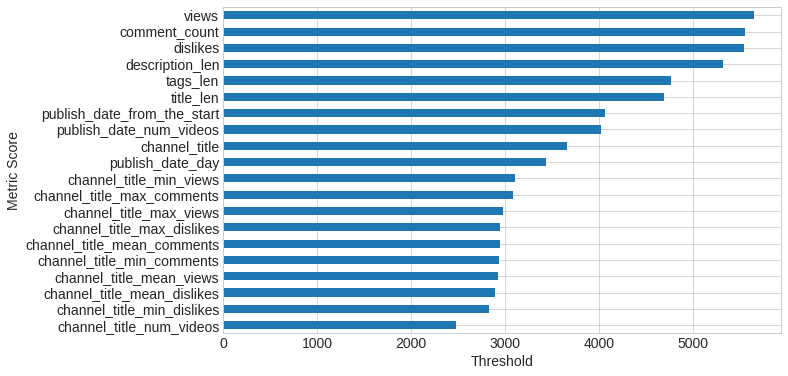

In [359]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)
optimal_thresh = get_optimal_f1_thresh(train_proc[TARGET_COL], lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')

**Submitting on the Leaderboard**

In [360]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'hacklive_lgb_text_cols_bow_newbhagwanO.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>